In [1]:
# Load packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3, venn3_circles

# 1 Data Import 

In [2]:
# IMPORT raw data 
deg_na = pd.read_csv('comp_anoxia_normoxia.csv', header=0, sep=',').assign(regulation='up', condition='Normoxia to Anoxia').rename(columns={'Unnamed: 0':'gene_id'})
deg_nr = pd.read_csv('comp_reoxygenation_normoxia.csv', header=0, sep=',').assign(regulation='up', condition='Normoxia to Reoxygenation').rename(columns={'Unnamed: 0':'gene_id'})
deg_ar = pd.read_csv('comp_anoxia_reoxygenation.csv', header=0, sep=',').assign(regulation='up', condition='Anoxia to Reoxygenation').rename(columns={'Unnamed: 0':'gene_id'})

# identified lncRNAs
# IMPORT DATA FROM COMMON
common = pd.read_csv('/home/maggy/LncRNA/6_identify_common_lncRNA/common_lncrna_gene_id.csv',)



In [3]:
# drop rows that contains NaN in the padj column 
deg_na = deg_na.dropna(subset=['padj'])
deg_nr = deg_nr.dropna(subset=['padj'])
deg_ar = deg_ar.dropna(subset=['padj'])

# filter for NaN in log2FoldChange column 
deg_na = deg_na.dropna(subset=['log2FoldChange'])
deg_nr = deg_nr.dropna(subset=['log2FoldChange'])
deg_ar = deg_ar.dropna(subset=['log2FoldChange'])

In [4]:
# substitute MSTRG in the dfs to STRG (to get the same format) 
# convert everything in lower case letters

degs = [deg_na, deg_nr, deg_ar]

def process_dfs(dfs):
    """
    Process a list of DataFrames to replace 'MSTRG.' with 'STRG.' in 'gene_id' column
    and convert 'gene_id' entries to lowercase.
    
    Parameters:
    dfs (list): List of DataFrames to process
    
    Returns:
    list: List of processed DataFrames
    """
    processed_dfs = []
    for df in dfs:
        df['gene_id'] = df['gene_id'].str.replace('MSTRG.', 'STRG.')
        df['gene_id'] = df['gene_id'].str.lower()
        processed_dfs.append(df)
    return processed_dfs

process_dfs(degs)   

[                   gene_id     baseMean  log2FoldChange     lfcSE      stat  \
 0                   strg.1  1161.487576        0.487665  0.062727  1.740125   
 1                   strg.2     0.995714       -1.337457  1.248161 -0.768287   
 2                   strg.3   148.424946       -0.498326  0.103499 -1.157637   
 3                   strg.4   106.220284       -0.106063  0.185338  0.000000   
 4                   strg.5   248.631957       -0.811516  0.079123 -5.472536   
 ...                    ...          ...             ...       ...       ...   
 41937   scaffold_72-g45758     6.139991       -1.234639  0.526786 -1.625189   
 41938   scaffold_72-g45759    21.408926        0.645049  0.246913  1.079479   
 41939   scaffold_72-g45760    22.210521        0.827403  0.241954  1.855273   
 41940  scaffold_129-g45565     5.475144       -0.715326  0.634966 -0.530444   
 41941  scaffold_129-g45566     3.505794        0.280240  0.616185  0.000000   
 
              pvalue          padj reg

In [5]:
# set threshold for fold change 
fold_threshold = 1.3 
p_threshold = 0.05

# 3 Vulcano DEG and lncRNA 

In [6]:
# merge the dataframes and add column with name of comparison
deg = pd.concat([deg_na, deg_nr, deg_ar])

# calculate -log10(padj) for each comparison
deg['-log10p'] = -np.log10(deg['padj'])

# introduce color code 
deg['color'] = 0

# color code for significant genes
deg.loc[abs(deg['log2FoldChange']) >= np.log2(fold_threshold) , 'color'] +=1
deg.loc[deg['padj'] <= p_threshold , 'color'] +=1
deg.loc[deg['gene_id'].isin(common['gene_id']), 'color'] +=1

# convert number code into str for Legend labels 
deg.loc[deg['color'] <= 1, 'color'] = 'Not Differentially Expressed'
deg.loc[deg['color'] == 2, 'color'] = 'Differentially Expressed'
deg.loc[deg['color'] == 3, 'color'] = 'Differentially Expressed LncRNA'

/home/maggy/anaconda3/envs/lncrna/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
# Define the conditions and directions
conditions = ['Normoxia to Anoxia', 'Normoxia to Reoxygenation', 'Anoxia to Reoxygenation']
directions = ['up', 'down']

# Create a dictionary to store the DataFrames
deg_dict = {}

# Iterate over conditions and directions
for condition in conditions:
    for direction in directions:
        if direction == 'up':
            log_condition = deg['log2FoldChange'] >= np.log2(fold_threshold)
        else:
            log_condition = deg['log2FoldChange'] <= -np.log2(fold_threshold)
            
        # Create the filtered DataFrame
        df = deg.loc[
            (deg['condition'] == condition) &
            (deg['color'].isin(['Differentially Expressed', 'Differentially Expressed LncRNA'])) &
            (deg['padj'] <= p_threshold) &
            log_condition
        ]
        
        # Store it in the dictionary with an appropriate key
        key = f"deg_{condition.replace(' ', '_').lower()}_{direction}"
        deg_dict[key] = df
        
        # Print the length of the DataFrame
        print(f"{key}: {len(df)}")

        # Save to CSV
        df.to_csv(f'deg_data/{key}.csv', index=False)

# Now each filtered DataFrame is accessible through deg_dict.


deg_normoxia_to_anoxia_up: 5693
deg_normoxia_to_anoxia_down: 5924
deg_normoxia_to_reoxygenation_up: 5119
deg_normoxia_to_reoxygenation_down: 4624
deg_anoxia_to_reoxygenation_up: 2698
deg_anoxia_to_reoxygenation_down: 1964


In [8]:
deg['color'].value_counts()

color
Not Differentially Expressed       86716
Differentially Expressed           25835
Differentially Expressed LncRNA     7897
Name: count, dtype: int64

In [9]:
# Vulcano plot
def add_deg_number(data, **kwargs):
    """Add the number of DEGs to each subplot."""
    if np.all(data['color'] == 'Not Differentially Expressed'):
        return 
    elif np.all(data['color'] == 'Differentially Expressed'):
        #(deg_na['log2FoldChange'] >= np.log2(fold_threshold)) & (deg_na['padj'] <= p_threshold )
        pos = sum((data['log2FoldChange'] >= np.log2(fold_threshold)) & (data['padj'] <= p_threshold))
        neg = sum((data['log2FoldChange'] <= -np.log2(fold_threshold)) & (data['padj'] <= p_threshold))
        plt.text(x=-15, y=250, s=fr'$\downarrow${neg}', fontsize=8, ha='center', va='center')
        plt.text(x=+15, y=250, s=fr'$\uparrow${pos}', fontsize=8, ha='center', va='center')
    elif np.all(data['color'] == 'Differentially Expressed LncRNA'):
        poslnc = sum((data['log2FoldChange'] >= np.log2(fold_threshold)) & (data['padj'] <= p_threshold) & (data['gene_id'].isin(common['gene_id'])))
        neglnc = sum((data['log2FoldChange'] <= -np.log2(fold_threshold)) & (data['padj'] <= p_threshold) & (data['gene_id'].isin(common['gene_id'])))
        plt.text(x=-15, y=200, s=fr'$\downarrow${neglnc}', fontsize=8, ha='center', va='center')
        plt.text(x=+15, y=200, s=fr'$\uparrow${poslnc}', fontsize=8, ha='center', va='center')

/home/maggy/anaconda3/envs/lncrna/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/maggy/anaconda3/envs/lncrna/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/maggy/anaconda3/envs/lncrna/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/maggy/anaconda3/envs/lncrna/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


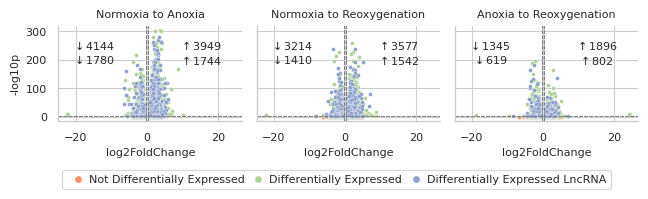

In [10]:
# create subplot for 3 plots 
sns.set_theme(style = 'whitegrid', palette='colorblind', context='paper', rc={'axes.labelsize':8, 'xtick.labelsize':8, 'ytick.labelsize':8, 'legend.fontsize':8, 'legend.title_fontsize':8})

g = sns.FacetGrid(deg, col="condition", hue='color', palette=['#FC8D62', '#AFD198', '#8DA0CB'], height=((4.5)/2.54), aspect=(17/4.5)/3)
g.refline(y=-np.log10(p_threshold), linestyle='--', linewidth=0.7, color='grey')
g.refline(x = np.log2(fold_threshold), linestyle='--', linewidth=0.7, color='grey')
g.refline(x = -np.log2(fold_threshold), linestyle='--', linewidth=0.7, color='grey')
g.map(sns.scatterplot, 'log2FoldChange','-log10p', s=8, rasterized=True)
g.add_legend(title='', fontsize=8, loc='upper center', borderaxespad=0.1, ncol=3, bbox_to_anchor=(.28, 0.02), frameon=True, markerscale=1.8, 
            columnspacing=0.2, scatteryoffsets=[0.5], handletextpad=0.01)
g.set_titles(col_template="{col_name}", fontsize=8)
g.map_dataframe(add_deg_number)
g.tight_layout()

# save as png
g.savefig('vulcano_deg_genes.svg', dpi=600)
plt.show()

In [11]:
# Define the conditions and directions
conditions = ['Normoxia to Anoxia', 'Normoxia to Reoxygenation', 'Anoxia to Reoxygenation']
directions = ['up', 'down']

# Create a dictionary to store the DataFrames
deg_dict = {}

# Iterate over conditions and directions
for condition in conditions:
    for direction in directions:
        if direction == 'up':
            log_condition = deg['log2FoldChange'] >= np.log2(fold_threshold)
        else:
            log_condition = deg['log2FoldChange'] <= -np.log2(fold_threshold)
            
        # Create the filtered DataFrame
        df = deg.loc[
            (deg['condition'] == condition) &
            (deg['color'].isin(['Differentially Expressed', 'Differentially Expressed LncRNA'])) &
            (deg['padj'] <= p_threshold) &
            log_condition
        ]
        
        # Store it in the dictionary with an appropriate key
        key = f"deg_{condition.replace(' ', '_').lower()}_{direction}"
        deg_dict[key] = df
        
        # Print the length of the DataFrame
        print(f"{key}: {len(df)}")

        # Save to CSV
        df.to_csv(f'deg_data/{key}.csv', index=False)

# Now each filtered DataFrame is accessible through deg_dict.


deg_normoxia_to_anoxia_up: 5693
deg_normoxia_to_anoxia_down: 5924
deg_normoxia_to_reoxygenation_up: 5119
deg_normoxia_to_reoxygenation_down: 4624
deg_anoxia_to_reoxygenation_up: 2698
deg_anoxia_to_reoxygenation_down: 1964
